# TO DO
### Explicar cada passo feito!
#### Reutilizar código

- Anotar critérios de avaliação - OK!
- Baixar os arquivos e importar - OK!
- EDA - OK! -> TESTAR OBSERVÇÕES NO FINAL
- Testing models - *reutilizar funções* - Adiconar novas métricas no df da função - OK!
- Utilizar os dados de teste - OK!
- Salvar arquivos de resultados(textos e resultado da classificação) - OK!
- Fazer o script de classificação baseado nos arquivos da API
- Criar um requirements.txt
- Ajietar o README.md
- Gravar apresentação

### Importando bibliotecas

Testar under-sampling no conjunto de treino, para diminuir o desbalanceamento do conjunto

In [1]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re
from collections import Counter
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from config import *
import datetime 
from functions import *
import pickle
from pathlib import Path  
from imblearn.under_sampling import RandomUnderSampler

### Importando arquivos

In [2]:
df_train = pd.read_csv("./data/train_binary_small.csv", encoding='utf-8')
df_test = pd.read_csv("./data/test_binary_small.csv",  encoding='utf-8')

In [3]:
df_train.head(3)

,id,comment_text,Toxic
0,0028d62e8a5629aa,All of my edits are good. Cunts like you who ...,Toxic
1,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,Toxic
2,00b77cb600c897b4,"""\n\nAnd you are? Let me know when you've craw...",Toxic


In [4]:
df_test.head(3)

,id,comment_text,Toxic
0,00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",Toxic
1,0013a435effa29bd,"I'd never think I'd need to say it, but Wikipe...",Non-Toxic
2,001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur...",Toxic


### Analysing data

-> Inicialmente iremos excluir a coluna de id, já que para a nossa análise precisamos apenas da colunas com os comentários e com os resultados de toxicidade

In [3]:
df_train =df_train.drop('id', axis=1)
df_test =df_test.drop('id', axis=1)

-> Agora iremos identificar se temos comentários vazios nos dois DataFrames, se sim iremos retirá-los

In [6]:
print(len(df_train))
df_train.isnull().sum()

2000


comment_text    0
Toxic           0
dtype: int64

In [7]:
print(len(df_test))
df_test.isnull().sum()

1500


comment_text    0
Toxic           0
dtype: int64

-> Agora iremos retirar comentários qu epossuem apenas espaços em branco, para isso utilizaremos uma função

In [4]:
df_train = removing_white_spaces_comments(df_train)
df_test = removing_white_spaces_comments(df_test)

[]
[]


Vimos que nossos dataframes também não possuíam nenhum comentário apenas com espaçoes em branco

-> Também vamos remover as pontuações, pois uma hipótese a ser testada é de que, essas não influenciam na nossa análise

In [4]:
df_train = removing_ponctuation_and_numbers(df_train, "comment_text", "comments_no_ponctuation")
df_train = removing_ponctuation_and_numbers(df_train, "comment_text", "total_treated_comments")

df_test = removing_ponctuation_and_numbers(df_test, "comment_text", "comments_no_ponctuation")
df_test = removing_ponctuation_and_numbers(df_test, "comment_text", "total_treated_comments")

Criaremos várias colunas para no final testá-las e vermos quais hipóteses são verdadeiras

-> Agora iremos analisar quais as principais palavras que se repetem nos cometários.

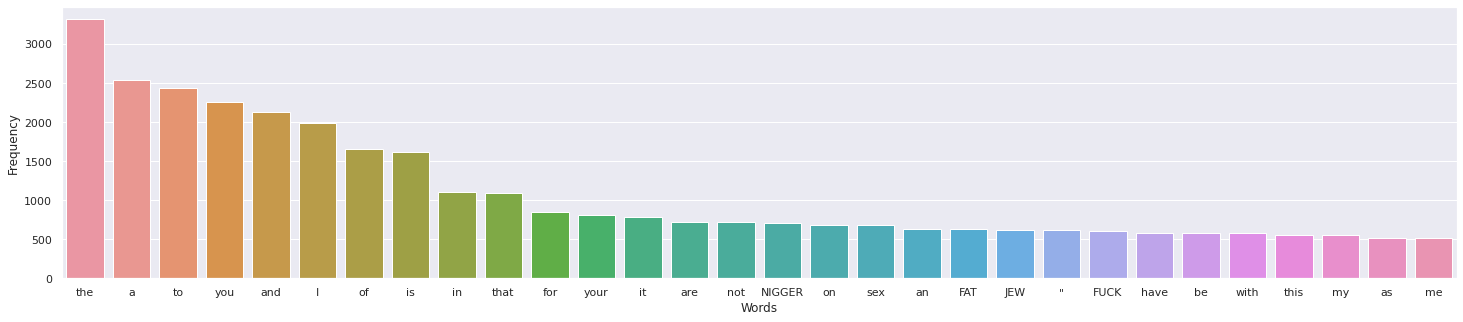

In [10]:
identifying_frequency(df_train,"comment_text")

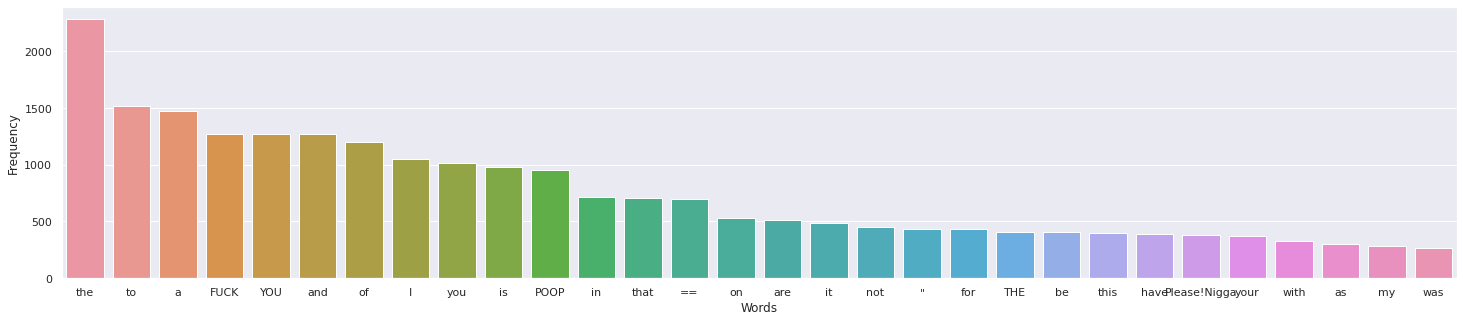

In [11]:
identifying_frequency(df_test,"comment_text")

-> Como a maioria das palavras que mais estão presentes no texto são stopwords podemos tentar removê-las para observar como isso influenciará no nosso modelo

In [5]:
df_train = removing_stop_words(df_train, "comment_text", "comments_no_stopwords")
df_train = removing_stop_words(df_train, "total_treated_comments", "total_treated_comments")

df_test = removing_stop_words(df_test, "comment_text", "comments_no_stopwords")
df_test = removing_stop_words(df_test, "total_treated_comments", "total_treated_comments")

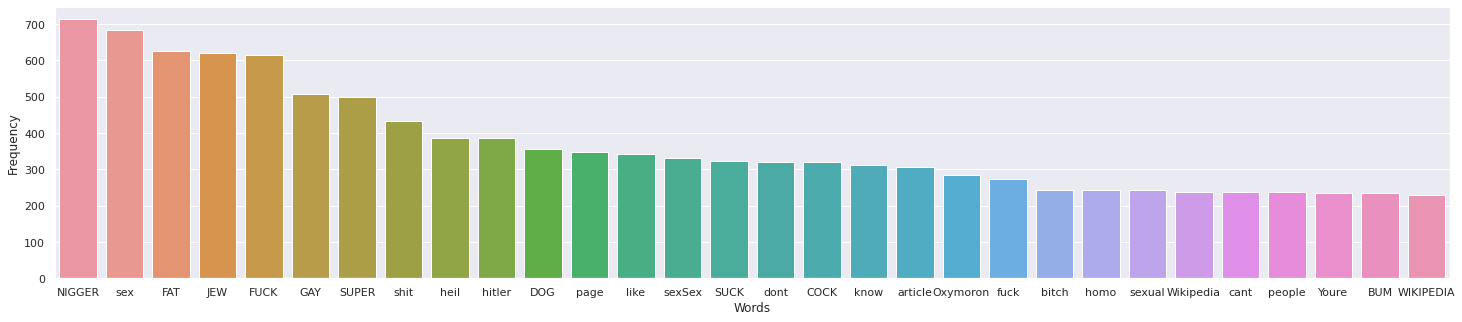

In [7]:
identifying_frequency(df_train,"total_treated_comments")

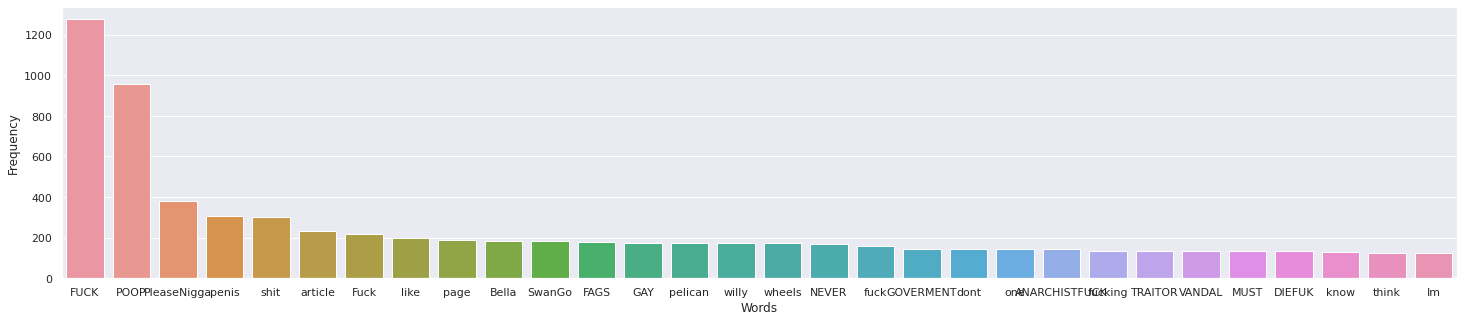

In [8]:
identifying_frequency(df_test,"total_treated_comments")

-> Outra hipótese que também podemos testar e aplicar a lemmatização e stemmatização nas colunas

In [6]:
#Lemmatização
df_train = lemmatizing_sentences(df_train, "comment_text", "lemm_comments")
df_train = lemmatizing_sentences(df_train, "total_treated_comments", "total_treated_comments")

df_test = lemmatizing_sentences(df_test, "comment_text", "lemm_comments")
df_test = lemmatizing_sentences(df_test, "total_treated_comments", "total_treated_comments")

In [7]:
#Stemmatização
df_train = stemming_sentences(df_train, "comment_text", "stemm_comments")
df_train = stemming_sentences(df_train, "total_treated_comments", "total_treated_comments")

df_test = stemming_sentences(df_test, "comment_text", "stemm_comments")
df_test = stemming_sentences(df_test, "total_treated_comments", "total_treated_comments")

In [8]:
#lemmatização + stemmatização
df_train = lemmatizing_sentences(df_train, "comment_text", "lemm_comments_and_stemm_comments")
df_train = stemming_sentences(df_train, "lemm_comments_and_stemm_comments", "lemm_comments_and_stemm_comments")

df_test = lemmatizing_sentences(df_test, "comment_text", "lemm_comments_and_stemm_comments")
df_test = stemming_sentences(df_test, "lemm_comments_and_stemm_comments", "lemm_comments_and_stemm_comments")

Agora tentaremos misturar alguns dos pré-processamentos

sem pontuação e números + sem stop word

In [9]:
df_train = removing_stop_words(df_train, "comments_no_ponctuation", "comments_no_ponctuation_no_stop_words")
df_test = removing_stop_words(df_test, "comments_no_ponctuation", "comments_no_ponctuation_no_stop_words")

lemmatização + Stemmatização + sem stop words

In [10]:
df_train = removing_stop_words(df_train, "lemm_comments_and_stemm_comments", "comments_lemm_stemm_no_stop_words")
df_test = removing_stop_words(df_test, "lemm_comments_and_stemm_comments", "comments_lemm_stemm_no_stop_words")

lemmatização + Stemmatização + sem pontuações e vírgulas

In [11]:
df_train = removing_ponctuation_and_numbers(df_train, "lemm_comments_and_stemm_comments", "comments_lemm_stemm_no_ponctuation")
df_test = removing_ponctuation_and_numbers(df_test, "lemm_comments_and_stemm_comments", "comments_lemm_stemm_no_ponctuation")

**Métricas** -> Acurácia e F1-score -> Utilizaremos a acurácia para prveer quando o nosso modelo está realmente correto e o f1-score para avaliar e quando os comentários são tóxicos, com que frequência eles são detectados, pois, é melhor apagarmos um comentário não tóxico do que deixarmos comentários tóxicos na rede.

In [19]:
vetorizadores = {
    'TFIDF':TfidfVectorizer(),
    'BOW':CountVectorizer()
}

#### Melhorar os hiperparâmetros dos vetorizadores

In [12]:
VECTORIZER_PARAMS = {
    'vetorizador__max_df': [0.5,0.6,0.7,0.8,0.9,1],
    'vetorizador__ngram_range':[(1,1),(1,2),(2,2),(1,3)],
}

In [13]:
columns = list(df_train.columns)
columns.remove("Toxic")

Para facilitar o processamento dos modelos iremos tranformar a coluna que clssifica os comentários em 0 e 1, sendo 1 para Toxic e 0 para Non-Toxic

In [14]:
df_train['Toxic'] = df_train['Toxic'].replace(['Toxic','Non-Toxic'],[1,0])
df_test['Toxic'] = df_test['Toxic'].replace(['Toxic','Non-Toxic'],[1,0])

Por questões de custos computacionais iremos manter o cv=5 e o n_iter=5 no RandomizedSearchCV e não utilizaremos o MLP como um possível classficador

In [23]:
for column in columns:
    x_train = df_train[column].tolist()
    x_test = df_test[column].tolist()
    y_train = df_train["Toxic"].tolist()
    y_test = df_test["Toxic"].tolist()
    print(f"Coluna: {column}")
    df = testing_models_random(MODELS, vetorizadores, VECTORIZER_PARAMS, x_train, y_train, x_test, y_test)
    display(df)
    print("--------------------------------------------")

Coluna: comment_text
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:17:13.768444
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:17:21.724862
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:17:21.725610
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:17:34.822869
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:17:34.824735
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:17:45.215274
Iniciou o modelo: RF_TFIDF
2022-11-23 12:17:45.216498
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:18:00.769512
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:18:00.769625
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:18:21.421337
Iniciou o modelo: Bayes_BOW
2022-11-23 12:18:21.421422
Fitting 5 folds for each of 5 candidates, to

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.671333,0.802246
1,KNN_TFIDF,0.792000,0.856221
2,DecisionTree_TFIDF,0.666667,0.800000
3,RF_TFIDF,0.666667,0.800000
4,SVM_TFIDF,0.802000,0.864939
5,Bayes_BOW,0.841333,0.889610
6,KNN_BOW,0.698667,0.811037
7,DecisionTree_BOW,0.721333,0.818103
8,RF_BOW,0.668000,0.800641
9,SVM_BOW,0.798000,0.857813


--------------------------------------------
Coluna: comments_no_ponctuation
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:19:29.709275
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:19:35.948763
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:19:35.948849
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:19:47.833175
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:19:47.834527
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:20:03.782116
Iniciou o modelo: RF_TFIDF
2022-11-23 12:20:03.782193
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:20:16.791304
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:20:16.792019
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:20:34.458686
Iniciou o modelo: Bayes_BOW
2022-11-23 12:2

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.670667,0.801925
1,KNN_TFIDF,0.776000,0.850534
2,DecisionTree_TFIDF,0.666667,0.800000
3,RF_TFIDF,0.666667,0.800000
4,SVM_TFIDF,0.762000,0.840554
5,Bayes_BOW,0.838667,0.887963
6,KNN_BOW,0.714000,0.817989
7,DecisionTree_BOW,0.708667,0.813963
8,RF_BOW,0.668000,0.800641
9,SVM_BOW,0.804667,0.865163


--------------------------------------------
Coluna: total_treated_comments
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:21:50.270550
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:21:55.908690
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:21:55.908777
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:22:01.904559
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:22:01.905497
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:22:09.007302
Iniciou o modelo: RF_TFIDF
2022-11-23 12:22:09.008604
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:22:19.894747
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:22:19.894833
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:22:38.812495
Iniciou o modelo: Bayes_BOW
2022-11-23 12:22

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.676667,0.804829
1,KNN_TFIDF,0.748667,0.837430
2,DecisionTree_TFIDF,0.717333,0.818648
3,RF_TFIDF,0.666667,0.800000
4,SVM_TFIDF,0.795333,0.857936
5,Bayes_BOW,0.822000,0.879240
6,KNN_BOW,0.700000,0.814662
7,DecisionTree_BOW,0.720667,0.821322
8,RF_BOW,0.666667,0.800000
9,SVM_BOW,0.784000,0.854578


--------------------------------------------
Coluna: comments_no_stopwords
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:23:30.529876
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:23:39.236547
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:23:39.236626
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:23:44.930717
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:23:44.931934
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:23:52.149679
Iniciou o modelo: RF_TFIDF
2022-11-23 12:23:52.151209
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:24:04.796841
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:24:04.798097
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:24:25.096875
Iniciou o modelo: Bayes_BOW
2022-11-23 12:24:

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.670667,0.801925
1,KNN_TFIDF,0.734667,0.831213
2,DecisionTree_TFIDF,0.721333,0.817786
3,RF_TFIDF,0.666667,0.800000
4,SVM_TFIDF,0.790000,0.857143
5,Bayes_BOW,0.815333,0.875056
6,KNN_BOW,0.668667,0.800802
7,DecisionTree_BOW,0.721333,0.817786
8,RF_BOW,0.666667,0.800000
9,SVM_BOW,0.673333,0.803055


--------------------------------------------
Coluna: lemm_comments
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:25:13.514713
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:25:25.082636
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:25:25.082709
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:25:38.166259
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:25:38.166380
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:25:50.949886
Iniciou o modelo: RF_TFIDF
2022-11-23 12:25:50.949962
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:26:03.695687
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:26:03.697274
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:26:43.919659
Iniciou o modelo: Bayes_BOW
2022-11-23 12:26:43.92114

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.671333,0.802246
1,KNN_TFIDF,0.783333,0.852474
2,DecisionTree_TFIDF,0.709333,0.783085
3,RF_TFIDF,0.666667,0.800000
4,SVM_TFIDF,0.830000,0.881561
5,Bayes_BOW,0.847333,0.887690
6,KNN_BOW,0.692000,0.809877
7,DecisionTree_BOW,0.714000,0.815642
8,RF_BOW,0.666667,0.800000
9,SVM_BOW,0.764667,0.839618


--------------------------------------------
Coluna: stemm_comments
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:27:55.294891
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:28:01.652163
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:28:01.652914
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:28:09.738374
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:28:09.739136
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:28:19.909154
Iniciou o modelo: RF_TFIDF
2022-11-23 12:28:19.909432
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:28:33.087239
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:28:33.088400
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:29:13.509391
Iniciou o modelo: Bayes_BOW
2022-11-23 12:29:13.5094

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.669333,0.801282
1,KNN_TFIDF,0.694667,0.811678
2,DecisionTree_TFIDF,0.715333,0.817443
3,RF_TFIDF,0.668000,0.800641
4,SVM_TFIDF,0.802000,0.858773
5,Bayes_BOW,0.846000,0.891905
6,KNN_BOW,0.708667,0.818295
7,DecisionTree_BOW,0.715333,0.817443
8,RF_BOW,0.668000,0.800641
9,SVM_BOW,0.770000,0.843253


--------------------------------------------
Coluna: lemm_comments_and_stemm_comments
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:30:23.418097
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:30:30.595955
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:30:30.596031
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:30:41.302469
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:30:41.304014
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:30:51.320564
Iniciou o modelo: RF_TFIDF
2022-11-23 12:30:51.320654
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:31:04.500435
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:31:04.500546
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:31:40.347898
Iniciou o modelo: Bayes_BOW
2022-1

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.668000,0.800641
1,KNN_TFIDF,0.751333,0.837897
2,DecisionTree_TFIDF,0.666667,0.800000
3,RF_TFIDF,0.668000,0.800641
4,SVM_TFIDF,0.816667,0.875283
5,Bayes_BOW,0.844000,0.890449
6,KNN_BOW,0.707333,0.817767
7,DecisionTree_BOW,0.716667,0.818143
8,RF_BOW,0.666667,0.800000
9,SVM_BOW,0.798000,0.859397


--------------------------------------------
Coluna: comments_no_ponctuation_no_stop_words
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:32:46.909925
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:32:50.771765
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:32:50.771854
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:32:56.645685
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:32:56.645765
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:33:00.035589
Iniciou o modelo: RF_TFIDF
2022-11-23 12:33:00.036931
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:33:06.679334
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:33:06.680071
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:33:23.203709
Iniciou o modelo: Bayes_BOW
2

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.670667,0.801925
1,KNN_TFIDF,0.741333,0.834188
2,DecisionTree_TFIDF,0.713333,0.817487
3,RF_TFIDF,0.666667,0.800000
4,SVM_TFIDF,0.775333,0.845200
5,Bayes_BOW,0.828000,0.882084
6,KNN_BOW,0.670667,0.801606
7,DecisionTree_BOW,0.718667,0.817947
8,RF_BOW,0.666667,0.800000
9,SVM_BOW,0.773333,0.849956


--------------------------------------------
Coluna: comments_lemm_stemm_no_stop_words
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:34:03.081428
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:34:08.465123
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:34:08.466606
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:34:12.887713
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:34:12.887800
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:34:19.896184
Iniciou o modelo: RF_TFIDF
2022-11-23 12:34:19.896262
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:34:29.693158
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:34:29.693455
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:34:45.780140
Iniciou o modelo: Bayes_BOW
2022-

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.674667,0.803859
1,KNN_TFIDF,0.738000,0.831692
2,DecisionTree_TFIDF,0.718000,0.815686
3,RF_TFIDF,0.666667,0.800000
4,SVM_TFIDF,0.718000,0.820077
5,Bayes_BOW,0.840000,0.889299
6,KNN_BOW,0.692000,0.810500
7,DecisionTree_BOW,0.716667,0.818143
8,RF_BOW,0.666667,0.800000
9,SVM_BOW,0.776667,0.852097


--------------------------------------------
Coluna: comments_lemm_stemm_no_ponctuation
Iniciou o modelo: Bayes_TFIDF
2022-11-23 12:35:32.289190
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: Bayes_TFIDF
2022-11-23 12:35:36.255272
Iniciou o modelo: KNN_TFIDF
2022-11-23 12:35:36.256567
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: KNN_TFIDF
2022-11-23 12:35:44.835709
Iniciou o modelo: DecisionTree_TFIDF
2022-11-23 12:35:44.835791
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: DecisionTree_TFIDF
2022-11-23 12:35:54.317352
Iniciou o modelo: RF_TFIDF
2022-11-23 12:35:54.317431
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: RF_TFIDF
2022-11-23 12:36:07.457247
Iniciou o modelo: SVM_TFIDF
2022-11-23 12:36:07.457314
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finalizou o modelo: SVM_TFIDF
2022-11-23 12:36:26.219496
Iniciou o modelo: Bayes_BOW
2022

,Modelo,acc,F1-score
0,Bayes_TFIDF,0.668667,0.800961
1,KNN_TFIDF,0.770667,0.847922
2,DecisionTree_TFIDF,0.666667,0.800000
3,RF_TFIDF,0.666667,0.800000
4,SVM_TFIDF,0.803333,0.868480
5,Bayes_BOW,0.839333,0.887436
6,KNN_BOW,0.695333,0.812012
7,DecisionTree_BOW,0.716667,0.818143
8,RF_BOW,0.666667,0.800000
9,SVM_BOW,0.803333,0.864118


--------------------------------------------


#### Escolhendo os melhores modelos

Com base nas tabelas geradas pude observar que o melhor modelo foi o Bayes com o vetorizador BOW, agora irei aplicar um gridsearch nesse para escolher a melhor coluna a ser utilizada.

Por questões de custos computacionais não utilizaremos o MLP como um possível classficador

In [15]:
vetorizadores = {
    'BOW':CountVectorizer()
}

In [16]:
df_total = testing_models_grid(SELECTED_MODEL, vetorizadores, VECTORIZER_PARAMS, df_train, df_test,columns)

Coluna: comment_text
Iniciou o modelo: Bayes_BOW
2022-11-23 14:22:53.796401
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_comment_text
2022-11-23 14:24:14.028619
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_comment_text,0.841333,0.88961


Coluna: comments_no_ponctuation
Iniciou o modelo: Bayes_BOW
2022-11-23 14:24:14.049164
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_comments_no_ponctuation
2022-11-23 14:25:30.666874
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_comments_no_ponctuation,0.84,0.888683


Coluna: total_treated_comments
Iniciou o modelo: Bayes_BOW
2022-11-23 14:25:30.686053
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_total_treated_comments
2022-11-23 14:26:18.345220
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_total_treated_comments,0.822,0.87924


Coluna: comments_no_stopwords
Iniciou o modelo: Bayes_BOW
2022-11-23 14:26:18.361520
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_comments_no_stopwords
2022-11-23 14:27:08.597581
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_comments_no_stopwords,0.828,0.881651


Coluna: lemm_comments
Iniciou o modelo: Bayes_BOW
2022-11-23 14:27:08.616357
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_lemm_comments
2022-11-23 14:28:26.858783
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_lemm_comments,0.84,0.888372


Coluna: stemm_comments
Iniciou o modelo: Bayes_BOW
2022-11-23 14:28:26.879358
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_stemm_comments
2022-11-23 14:29:42.009916
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_stemm_comments,0.842667,0.889616


Coluna: lemm_comments_and_stemm_comments
Iniciou o modelo: Bayes_BOW
2022-11-23 14:29:42.031871
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_lemm_comments_and_stemm_comments
2022-11-23 14:30:56.459243
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_lemm_comments_and_stemm_comments,0.842,0.889097


Coluna: comments_no_ponctuation_no_stop_words
Iniciou o modelo: Bayes_BOW
2022-11-23 14:30:56.483531
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_comments_no_ponctuation_no_stop_words
2022-11-23 14:31:51.476845
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_comments_no_ponctuation_no_stop_words,0.828,0.882084


Coluna: comments_lemm_stemm_no_stop_words
Iniciou o modelo: Bayes_BOW
2022-11-23 14:31:51.495871
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_comments_lemm_stemm_no_stop_words
2022-11-23 14:32:51.866402
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_comments_lemm_stemm_no_stop_words,0.84,0.889299


Coluna: comments_lemm_stemm_no_ponctuation
Iniciou o modelo: Bayes_BOW
2022-11-23 14:32:51.886056
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Finalizou o modelo: Bayes_BOW_comments_lemm_stemm_no_ponctuation
2022-11-23 14:34:03.283815
--------------------------------------------


,Modelo,acc,F1-score
0,Bayes_BOW_comments_lemm_stemm_no_ponctuation,0.839333,0.887436


,Modelo,acc,F1-score
0,Bayes_BOW_comment_text,0.841333,0.889610
1,Bayes_BOW_comments_no_ponctuation,0.840000,0.888683
2,Bayes_BOW_total_treated_comments,0.822000,0.879240
3,Bayes_BOW_comments_no_stopwords,0.828000,0.881651
4,Bayes_BOW_lemm_comments,0.840000,0.888372
5,Bayes_BOW_stemm_comments,0.842667,0.889616
6,Bayes_BOW_lemm_comments_and_stemm_comments,0.842000,0.889097
7,Bayes_BOW_comments_no_ponctuation_no_stop_words,0.828000,0.882084
8,Bayes_BOW_comments_lemm_stemm_no_stop_words,0.840000,0.889299
9,Bayes_BOW_comments_lemm_stemm_no_ponctuation,0.839333,0.887436


### **A partir das tabelas acima chegamos a conclusão de que a melhor coluna para inserirmos no nosso modelo é a coluna onde realizamos apenas a stemmatização! Pois ela possui tanto o maior valor de acurácia quanto de f1-score e além disso, a diferença do seu tempo de processamento para o tempo das outras colunas não é grande suficiente par aoptarmos por outra coluna**

#### **Link para o GitHub:** https://github.com/deboramendes2706/avaliacao_lead
